# GAN per riconoscimento eventi
Riconosce se una sequenza di valori è inusuale

In [1665]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1666]:
tf.reset_default_graph()

In [1667]:
df_pm = pd.read_json("dati_milano/pm10_11_18.json").reset_index()["pm10"]
df_lambrate = pd.read_csv("dati_milano/aria_lambrate_2602181_260219/RW_20190227172304_45400_10273_1.csv", names = ["data", "pm10"]).iloc[2:]["pm10"].reset_index()["pm10"]

In [1668]:
df = df_pm.append(df_lambrate).reset_index()["pm10"]

In [1669]:
df = df.dropna()

In [1670]:
df.head()

0    35
1    21
2    17
3    14
4    22
Name: pm10, dtype: object

In [1671]:
n_steps = 30
n_inputs = 1
n_neurons = 40
n_outputs = 1

In [1672]:
resolution = 1
lun = len(df) - n_steps

def time_series(t):
    array = []
    for x in t:
        array.append(df.iloc[x].values)
    return np.array(array).copy()

def next_batch(batch_size, n_steps):
    t0 = np.random.randint(lun, size = (batch_size, 1))
    Ts = t0 + np.arange(0, n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, n_inputs)

In [1673]:
def generator(X, reuse = None):
    with tf.variable_scope('gen',reuse = reuse):
        cell = [tf.keras.layers.GRUCell(units = n_neurons, activation = "tanh"),
            tf.keras.layers.GRUCell(units = int(n_neurons / 2), activation = "tanh")
        ]
        layer = tf.keras.layers.RNN(cell, dtype=tf.float32, return_state = False, return_sequences = True)(X)
        outputs = tf.keras.layers.Dense(1)(layer)
        #outputs = tf.keras.layers.LeakyReLU(alpha=-1)(outputs)
        outputs = tf.keras.layers.Reshape((-1, n_outputs))(outputs)

    return outputs

In [1674]:
def discriminator(X, reuse = None):
    with tf.variable_scope('dis', reuse = reuse):
        cell = [tf.keras.layers.GRUCell(units = n_neurons, activation = "relu"),
            tf.keras.layers.GRUCell(units = int(n_neurons / 2), activation = "relu")
        ]
        layer = tf.keras.layers.RNN(cell, dtype=tf.float32, return_state = False, return_sequences = True)(X)
        activation_layer = tf.keras.layers.LeakyReLU(alpha=0.1)(layer)
        logits = tf.keras.layers.Dense(1)(activation_layer)
        output = tf.sigmoid(logits)
        
    return output,logits

In [1675]:
valori_veri = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
z = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [1676]:
G = generator(z, reuse = False)

In [1677]:
D_output_reale, D_logits_reale = discriminator(valori_veri)
D_output_fake, D_logits_fake = discriminator(G, reuse = True)

In [1678]:
def loss_func(logits_in, labels_in):
    # return tf.reduce_mean(tf.abs(tf.abs(logits_in) - tf.abs(labels_in)))
    # Con logits:
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [1679]:
D_reale_loss = loss_func(D_logits_reale, tf.ones_like(D_logits_reale))
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake))

In [1680]:
D_loss = D_reale_loss + D_fake_loss

In [1681]:
G_loss = loss_func(D_output_fake, tf.ones_like(D_logits_fake))

In [1682]:
learning_rate = 0.001

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

D_trainer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(D_loss, var_list = d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(G_loss, var_list = g_vars)

In [1683]:
init = tf.global_variables_initializer()

In [1684]:
batch_size = 30
epochs = 100

In [1685]:
saver = tf.train.Saver()

In [1686]:
n_iterations = 200

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch = next_batch(batch_size, n_steps)
        batch_z = np.random.uniform(1, 100, size = (batch_size, n_steps, n_inputs))
        sess.run(D_trainer, feed_dict = {valori_veri:X_batch, z:batch_z})
        sess.run(G_trainer, feed_dict = {z:batch_z})
        if iteration % 10 == 0 or iteration == n_iterations - 1:
            errore_D_reale = D_reale_loss.eval(feed_dict = {valori_veri:X_batch, z:batch_z})
            errore_D_fake = D_fake_loss.eval(feed_dict = {valori_veri:X_batch, z:batch_z})
            print(iteration, "\tAccuracy d_reale:", errore_D_reale, "\tAccuracy d_fake:", errore_D_fake)
            
    
    saver.save(sess, "./modelli/GAN")

0 	Accuracy d_reale: 1.7325516 	Accuracy d_fake: 0.7065092
10 	Accuracy d_reale: 0.15942675 	Accuracy d_fake: 0.6798593
20 	Accuracy d_reale: 0.05032011 	Accuracy d_fake: 0.5568476
30 	Accuracy d_reale: 0.020541344 	Accuracy d_fake: 0.5535038
40 	Accuracy d_reale: 0.015320388 	Accuracy d_fake: 0.5881251
50 	Accuracy d_reale: 0.008401039 	Accuracy d_fake: 0.488408
60 	Accuracy d_reale: 0.0060735247 	Accuracy d_fake: 0.448823
70 	Accuracy d_reale: 0.0066489186 	Accuracy d_fake: 0.3160986
80 	Accuracy d_reale: 0.003766067 	Accuracy d_fake: 0.08939805
90 	Accuracy d_reale: 0.0050383136 	Accuracy d_fake: 0.055541746
100 	Accuracy d_reale: 0.0040653683 	Accuracy d_fake: 0.046192992
110 	Accuracy d_reale: 0.0023931144 	Accuracy d_fake: 0.041253418
120 	Accuracy d_reale: 0.0055936244 	Accuracy d_fake: 0.037996937
130 	Accuracy d_reale: 0.001870731 	Accuracy d_fake: 0.035523806
140 	Accuracy d_reale: 0.0041503226 	Accuracy d_fake: 0.033493176
150 	Accuracy d_reale: 0.0041048722 	Accuracy d_fake

In [1687]:
with tf.Session() as sess:
    saver.restore(sess, "./modelli/GAN")
    batch_z = np.random.uniform(0, 100, size = (batch_size, n_steps, n_inputs))
    res = sess.run(G, feed_dict = {z:batch_z})

INFO:tensorflow:Restoring parameters from ./modelli/GAN


La sequenza generata dal GAN:

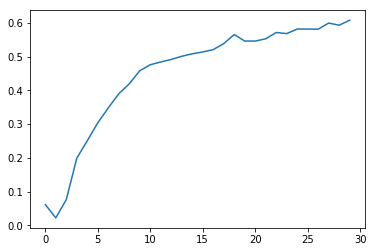

In [1688]:
plt.plot(np.abs(res[-1]))

Un esempio di sequenza reale:

In [1689]:
random_start = np.random.randint(df.shape[0] - n_steps) 
test_val = df[random_start:random_start + n_steps].values.reshape(1, n_steps, n_inputs)

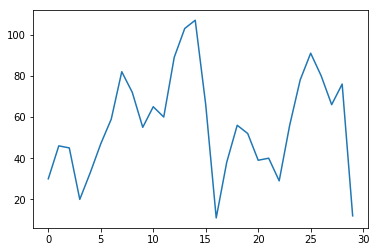

In [1690]:
plt.plot(test_val[0, :])

## TEST

In [1691]:
with tf.Session() as sess:
    saver.restore(sess, "./modelli/GAN")
    res_test_ok = sess.run(D_output_reale, feed_dict = {valori_veri:test_val})

INFO:tensorflow:Restoring parameters from ./modelli/GAN


Il discriminator riconosce che è giusta?

In [1692]:
"Probabilità che sia giusta la giusta: {:.2%}".format(res_test_ok.mean())

'Probabilità che sia giusta la giusta: 99.95%'

Stesso con una distribuzione casuale ma in un intervallo sensato:

In [1693]:
test_rand = np.random.uniform(10, 100, size = (batch_size, n_steps, n_inputs))

with tf.Session() as sess:
    saver.restore(sess, "./modelli/GAN")
    res_test_rand = sess.run(D_output_reale, feed_dict = {valori_veri:test_rand})

INFO:tensorflow:Restoring parameters from ./modelli/GAN


In [1694]:
"Probabilità che sia giusta la sbagliata: {:.2%}".format(res_test_rand.mean())

'Probabilità che sia giusta la sbagliata: 99.90%'